In [3]:
from kirchhoffmigration import PlotImg, full_migration, taper
import numpy as np
import matplotlib.pyplot as plt

ntrc = 101
noff = 5
nsmp = 1001
dt = 0.002
offsets = np.array([0, 500, 1000, 1500, 2000])
nz=300
dx=20
dz=10
nx=1
dcdp=20

# f = open('./data/SEIS-filt', 'r')
f = open('./data/SEIS-orig', 'r')
# read data in ieee754 format
inputs = np.fromfile(f, dtype=np.float32)
# reshape
data = inputs.reshape(noff,ntrc,nsmp)
fig = plt.figure()

colormap='gist_yarg'
##########################
#PlotImg(data,'unprocessed', 1001, colormap='gray', nx=1, nz=300, dt=0.002, dx=20, dz=10, dcdp=20, offsets=offsets)
data2d = data.reshape(noff*ntrc, 1001)
ax1 = fig.add_subplot(3, 1, 1)
ax1.imshow(data2d.T, extent=[0,ntrc*dx*noff, nz*dz,0],cmap=colormap)
# v_analysis(2000, 5000)
# v_analysis results in v=2950 at a depth of z=1970

migrated = full_migration(data, nx=1, nz=300, dt=0.002, dx=20, dz=10, dcdp=20, offsets=offsets)
data2d = migrated.reshape(noff*ntrc, 300)
ax2 = fig.add_subplot(3, 1, 2)
ax2.imshow(data2d.T, extent=[0,ntrc*dx*noff, nz*dz,0],cmap=colormap)


taperdata = taper(data)
migrated = full_migration(taperdata, nx=1, nz=300, dt=0.002, dx=20, dz=10, dcdp=20, offsets=offsets)
data2d = migrated.reshape(noff*ntrc, 300)
ax3 = fig.add_subplot(3, 1, 3)
ax3.imshow(data2d.T, extent=[0,ntrc*dx*noff, nz*dz,0],cmap=colormap)
#PlotImg(migrated, 'migrated_data', 300, colormap='gray', nx=1, nz=300, dt=0.002, dx=20, dz=10, dcdp=20, offsets=offsets)


# ## taper the data to reduce artifacts
# taperdata = taper(data)
# PlotImg(taperdata,'tapered_original_data', 1001)

# migrated_tapered = full_migration(taperdata)
# PlotImg(migrated_tapered, 'migrated_tapered_data', 300)

###################################
#benchmark()
# PlotSpectrum(59)
# zm = plot_zm()
# check_amplitudes(data)


FileNotFoundError: [Errno 2] No such file or directory: 'SEIS-orig'

In [3]:
import numpy as np

ntrc = 101
noff = 5
nsmp = 1001

dt = 0.002


offsets = np.array([0, 500, 1000, 1500, 2000])

nz=300
dx=20
dz=10
nx=1
dcdp=20



colormap = 'gist_yarg'

f = open('SEIS-filt', 'r')
# read data in ieee754 format
inputs = np.fromfile(f, dtype=np.float32)
# reshape
data = inputs.reshape(noff,ntrc,nsmp)


In [4]:
data.shape

(5, 101, 1001)

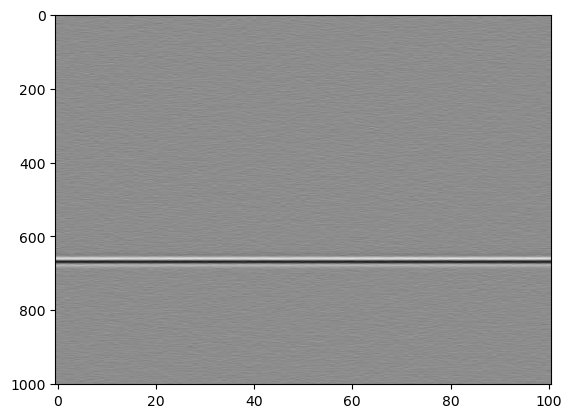

In [7]:
plt.imshow(data[1].T, aspect='auto', cmap=colormap)

In [ ]:


##########################
PlotImg(data,'unprocessed', 1001)

# v_analysis(2000, 5000)
# v_analysis results in v=2950 at a depth of z=1970



migrated = full_migration(data)
PlotImg(migrated, 'migrated_data', 300)


## taper the data to reduce artifacts
taperdata = taper(data)
PlotImg(taperdata,'tapered_original_data', 1001)

migrated_tapered = full_migration(taperdata)
PlotImg(migrated_tapered, 'migrated_tapered_data', 300)

###################################
#benchmark()
# PlotSpectrum(59)
# zm = plot_zm()
# check_amplitudes(data)

In [1]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.fftpack

import mod_cyMigrate

def PlotSpectrum(trace):
    '''
    calculate and plot frequency spectrum of a single trace
    '''
    # use unfiltered data for that
    f = open('SEIS-orig', 'r')
    # read data in ieee754 format
    inputs = np.fromfile(f, dtype=np.float32)
    # reshape
    data = inputs.reshape(noff,ntrc,nsmp)

    FFT = abs(scipy.fft(data[1,trace,:]))
    freqs = scipy.fftpack.fftfreq(data[1,1,:].size, dt)

    half = len(freqs)//2
    # plot
    plt.figure()
    plt.plot(freqs[0:half],FFT[0:half],'#384c80',linewidth=2)
    #plt.xlim([0,200])
    plt.xlabel('Frequency in [Hz]')

    plt.savefig('./figures/spectrum.eps', bbox_inches=0)



def PlotImg(data2d,name, ndepth):
    data2d = data2d.reshape(noff*ntrc,ndepth)

    filepath = "./figures/" + name + ".eps"

    plt.figure()
    imgplot = plt.imshow(data2d.T, extent=[0,ntrc*dx*noff, nz*dz,0],cmap=colormap)

    # lines and offsets
    for i in range(noff):
        plt.axvline(linewidth=2, color='k',x=(i+1)*ntrc*dx)
        plt.text((i+1)*ntrc*dx-ntrc*dx/2,nz*dz+50,offsets[i],verticalalignment='top',horizontalalignment='center')        #custom axis

    # new x axis
    plt.gca().axes.get_xaxis().set_ticks([])  # hide original


    plt.axes().set_aspect('auto')                       # set aspect ratio to auto
    plt.xlabel('\n\nOffset')
    plt.ylabel('Time in [s]')
    plt.savefig(filepath, bbox_inches=0)

def Migrate(data,nx,dx,nz,dz,dt,dcdp,v,offsets,nsmp,ntrc,noff,ioff):

    R = np.zeros((nx, nz))
    for ix in range(0, nx):        #loop over discreticized undergroundpoints in x
        x = dx*ix
        for iz in range(1, nz):    #loop over discreticized undergroundpoints in z
            z = dz*iz               #(depth)

            for itrc in range(0, ntrc):     #loop over all traces
                ksi = dcdp * itrc           # cdp point
                # h = offsets[ioff]//2         # half offset
                h = offsets[ioff]/2         # half offset
                rs = np.sqrt( (x - (ksi-h))**2 + z**2)     # distance point<->source
                rr = np.sqrt( (x - (ksi+h))**2 + z**2)     # distance point<->reciever

                wco = ( z/rs * np.sqrt(rs/rr) + z/rr * np.sqrt(rr/rs) ) /v

                t = (rs + rr)/v             # resulting time
                it = np.floor(t/dt)         # nearest neighbor for timesample

                #print rs, rr, ix, iz, t, it
                if (it <= nsmp-1):
                    R[ix,iz] = R[ix,iz] + data[ioff,itrc,it] * wco /np.sqrt(2*np.pi)
    return R

def benchmarkfunc(mode):
    nx=1
    if (mode == 'python'):
        R = Migrate(data,nx,dx,nz,dz,dt,dcdp,3000,offsets,nsmp,ntrc,noff,1)
    if (mode == 'cython'):
        R = mod_cyMigrate.cyMigrate(data,nx,dx,nz,dz,dt,dcdp,3000,offsets,nsmp,ntrc,noff,1)



def benchmark():
    import timeit
    nx = 1
    print("Benchmarking python vs cython:")
    print("Migrating 10 times with nx=",nx)
    print("python code:")
    py_time = timeit.timeit("kirchhoffmigration.benchmarkfunc('python')",setup="import kirchhoffmigration", number=10)
    print(py_time)

    print("cython code:")
    cy_time = timeit.timeit("kirchhoffmigration.benchmarkfunc('cython')",setup="import kirchhoffmigration", number=10)
    print(cy_time)



def v_analysis(vmin, vmax):
    '''
    Velocity analysis due to testing a range of velocities (from vmin to vmax)
    plotting them together in one plot.
    '''

    nvels = 100                         # number of velocities to be tested
    V = np.linspace(vmin,vmax,nvels)
    nx=1                                # only compute one trace
    M = np.zeros((nz, nvels))
    for n in range(0, len(V)-1):
        R = mod_cyMigrate.cyMigrate(data,nx,dx,nz,dz,dt,dcdp,V[n],offsets,nsmp,ntrc,noff,1)
        M[:,n] = R[0,:]

    plt.figure()
    imgplot = plt.imshow(M, extent=[vmin, vmax, nz*dz, dz])
    plt.ylabel('Depth in [m]')
    plt.xlabel('Velocity in [m/s]')
    plt.savefig('./figures/v_analysis.eps', bbox_inches=0)
    plt.show()

    return M

def full_migration(data):
    nx = ntrc
    V = 2950

    R = np.zeros((noff,nx, nz))
    for ioff in range(noff):            # each offset in its own layer
        R[ioff,:,:] = mod_cyMigrate.cyMigrate(data,nx,dx,nz,dz,dt,dcdp,V,offsets,nsmp,ntrc,noff,ioff)
    return R

def plot_offsets(data,name):

    data2d = data.reshape(noff*ntrc,nz)
    filepath = "./figures/" + name + ".eps"
    plt.figure()
    plt.imshow(data2d.T, extent=[0,ntrc*dx*noff, nz*dz,0], cmap=colormap)

    # lines and offsets
    for i in range(noff):
        plt.axvline(linewidth=2, color='k',x=(i+1)*ntrc*dx)
        plt.text((i+1)*ntrc*dx-ntrc*dx/2,nz*dz+50,offsets[i],verticalalignment='top',horizontalalignment='center')        #custom axis

    # new x axis
    plt.gca().axes.get_xaxis().set_ticks([])  # hide original

    plt.ylabel('Depth z in [m]')
    plt.xlabel('\n\nOffset')
    plt.savefig(filepath, bbox_inches='tight')
    plt.show()





def taper(data,traces=20):
    '''
    Tapers the data to reduce migration artifacts via sinus curve.
    Optional Parameter traces: Number of traces to be affected.
    '''

    amount = list()
    i = 0
    for x in np.linspace(0, np.pi/2,traces):
        amount.append(np.sin(x))
        i=i+1

    for off in range(0,noff):
        for n in range(0,traces):
            data[off,n,:] = data[off,n,:]*amount[n]
            data[off,ntrc-1-n,:] = data[off,ntrc-1-n,:]*amount[n]

    return data

def check_amplitudes(data):
    maxamp = np.zeros((noff, data.shape[1]))
    for ioff in range(noff):
        for i in range(0,data.shape[1]):
            maxamp[ioff,i] = (max(abs(data[ioff,i,:])))


    #plot
    colors = ["#a5b7e6","#274db3","#296f80","#8d6450","#b34127"]
    plt.figure()
    for i in range(noff):
        plt.plot(range(data.shape[1]),maxamp[i,:],colors[i],label="Offset %dm"%(i*500),linewidth=2)

    plt.legend(loc="lower center")
    plt.xlabel('Trace')
    plt.ylabel('Maximum amplitude')

    plt.savefig('./figures/amplitudes.eps', bbox_inches=0)

    return maxamp

def v_analysis2(data,h1,h2,v):
    nx=1

    off1 = mod_cyMigrate.cyMigrate(data,nx,dx,nz,dz,dt,dcdp,v,offsets,nsmp,ntrc,noff,h1)
    off2 = mod_cyMigrate.cyMigrate(data,nx,dx,nz,dz,dt,dcdp,v,offsets,nsmp,ntrc,noff,h2)


    zm1 = np.argmax(off1)*dz
    zm2 = np.argmax(off2)*dz


    h12 = (offsets[h1]/2)**2
    h22 = (offsets[h2]/2)**2

    print(zm1,zm2,h12,h22)

    v0 = v * (np.sqrt((zm1**2 - zm2**2)/(h12-h22) +1 ))**-1


    return(v0)


def plot_zm():

    z0 = 1
    v0 = 1

    hlist = np.linspace(0,3,100)
    zm = np.zeros((3,100))

    i=0
    n=0
    for vm in [0.9*v0, v0, 1.1*v0]:
        for h in hlist:
            zm[i,n] = np.sqrt(vm**2 * (h**2+z0**2)/(v0**2)-h**2)

            n=n+1
        n=0
        i=i+1

    plt.figure()
    plt.plot(hlist,zm[0,:],'#8d6450',label='$v_m = 0.9v_0$',linewidth=2)
    plt.plot(hlist,zm[1,:],'#274db3',label='$v_m = 1.0v_0$',linewidth=2)
    plt.plot(hlist,zm[2,:],'#b34127',label='$v_m = 1.1v_0$',linewidth=2)

    plt.legend(loc="lower left")

    plt.xlabel('$h/z_0$',fontsize=15)
    plt.ylabel('$z_m/z_0$',fontsize=15)

    plt.savefig('./figures/zmh.eps', bbox_inches=0)
    plt.show()


    return zm

##################################################################

ntrc = 101
noff = 5
nsmp = 1001

dt = 0.002


offsets = np.array([0, 500, 1000, 1500, 2000])

nz=300
dx=20
dz=10
nx=1
dcdp=20



colormap = 'gist_yarg'

f = open('SEIS-filt', 'r')
# read data in ieee754 format
inputs = np.fromfile(f, dtype=np.float32)
# reshape
data = inputs.reshape(noff,ntrc,nsmp)


##########################
PlotImg(data,'unprocessed', 1001)

# v_analysis(2000, 5000)
# v_analysis results in v=2950 at a depth of z=1970



migrated = full_migration(data)
PlotImg(migrated, 'migrated_data', 300)


## taper the data to reduce artifacts
taperdata = taper(data)
PlotImg(taperdata,'tapered_original_data', 1001)

migrated_tapered = full_migration(taperdata)
PlotImg(migrated_tapered, 'migrated_tapered_data', 300)

###################################
#benchmark()
# PlotSpectrum(59)
# zm = plot_zm()
# check_amplitudes(data)

ModuleNotFoundError: No module named 'mod_cyMigrate'